# Customer Churn Prediction

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

## Description

A marketing agency has many customers that use their service to produce ads for the client/customer websites. They've noticed that they have quite a bit of churn in clients. They basically randomly assign account managers right now, but want you to create a machine learning model that will help predict which customers will churn (stop buying their service) so that they can correctly assign the customers most at risk to churn an account manager. Luckily they have some historical data, can you help them out? Create a classification algorithm that will help classify whether or not a customer churned. Then the company can test this against incoming data for future customers to predict which customers will churn and assign them an account manager.

Here are the fields and their definitions:

    Name : Name of the latest contact at Company
    Age: Customer Age
    Total_Purchase: Total Ads Purchased
    Account_Manager: Binary 0=No manager, 1= Account manager assigned
    Years: Totaly Years as a customer
    Num_sites: Number of websites that use the service.
    Onboard_date: Date that the name of the latest contact was onboarded
    Location: Client HQ Address
    Company: Name of Client Company
    
Once you've created the model and evaluated it, test out the model on some new data (you can think of this almost like a hold-out set) that your client has provided, saved under new_customers.csv. The client wants to know which customers are most likely to churn given this data (they don't have the label yet).

## Start spark session

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('churn').getOrCreate()

## Load the data

In [4]:
data = spark.read.csv('data/customer_churn.csv',inferSchema=True, header=True)

In [5]:
data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [6]:
data.head()

Row(Names='Cameron Williams', Age=42.0, Total_Purchase=11066.8, Account_Manager=0, Years=7.22, Num_Sites=8.0, Onboard_date=datetime.datetime(2013, 8, 30, 7, 0, 40), Location='10265 Elizabeth Mission Barkerburgh, AK 89518', Company='Harvey LLC', Churn=1)

In [7]:
from pyspark.sql.functions import format_number
data_info = data.describe()
data_info.select('Names',
                 format_number(data_info['Age'].cast('double'),2).alias('Age'),
                 format_number(data_info['Total_Purchase'].cast('double'),2).alias('Total_Purchase'),
                 format_number(data_info['Account_Manager'].cast('double'),2).alias('Account_Manager'),
                 format_number(data_info['Years'].cast('double'),2).alias('Years'),
                 format_number(data_info['Num_Sites'].cast('double'),2).alias('Num_Sites'),
                 'Location',
                 'Company'
).show()

+-------------+------+--------------+---------------+------+---------+--------------------+--------------------+
|        Names|   Age|Total_Purchase|Account_Manager| Years|Num_Sites|            Location|             Company|
+-------------+------+--------------+---------------+------+---------+--------------------+--------------------+
|          900|900.00|        900.00|         900.00|900.00|   900.00|                 900|                 900|
|         null| 41.82|     10,062.82|           0.48|  5.27|     8.59|                null|                null|
|         null|  6.13|      2,408.64|           0.50|  1.27|     1.76|                null|                null|
|   Aaron King| 22.00|        100.00|           0.00|  1.00|     3.00|00103 Jeffrey Cre...|     Abbott-Thompson|
|Zachary Walsh| 65.00|     18,026.01|           1.00|  9.15|    14.00|Unit 9800 Box 287...|Zuniga, Clark and...|
+-------------+------+--------------+---------------+------+---------+--------------------+-----

## Create a feature vector which MLlib can use

We'll use the numerical columns. We'll include Account Manager because its easy enough, but keep in mind it probably won't be significant because the agency mentioned its randomly assigned!

In [8]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [9]:
data_vectorized = VectorAssembler(inputCols=['Age','Total_Purchase','Account_Manager','Years','Num_Sites'],
                            outputCol='features').transform(data).select(['features', 'Churn'])

In [10]:
data_vectorized.show()

+--------------------+-----+
|            features|Churn|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
|[30.0,11575.37,1....|    1|
|[45.0,8771.02,1.0...|    1|
|[45.0,8988.67,1.0...|    1|
|[40.0,8283.32,1.0...|    1|
|[41.0,6569.87,1.0...|    1|
|[38.0,10494.82,1....|    1|
|[45.0,8213.41,1.0...|    1|
|[43.0,11226.88,0....|    1|
|[53.0,5515.09,0.0...|    1|
|[46.0,8046.4,1.0,...|    1|
+--------------------+-----+
only showing top 20 rows



In [11]:
data_vectorized.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



## Fit the model

In [12]:
train_churn,test_churn = data_vectorized.randomSplit([0.7,0.3])

In [13]:
from pyspark.ml.classification import LogisticRegression

In [14]:
churn_model = LogisticRegression(labelCol='Churn').fit(train_churn)

In [15]:
training_sum = churn_model.summary

In [16]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
from ggplot import *

/home/khurram/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/khurram/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/khurram/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


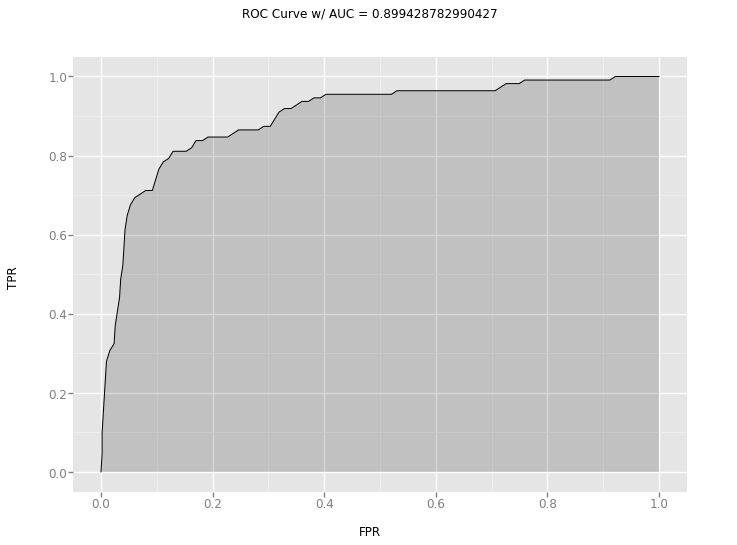

<ggplot: (8738478954125)>

In [17]:
ggplot(training_sum.roc.toPandas(), aes(x = 'FPR', y = 'TPR')) \
+ geom_line(aes(y = 'TPR'))\
+ geom_area(alpha = 0.2) \
+ ggtitle("ROC Curve w/ AUC = %s" % str(training_sum.areaUnderROC)) 

## Evaluate the model

Let's evaluate the results on the data set we were given (using the test data)

In [18]:
pred_and_labels = churn_model.evaluate(test_churn)

In [19]:
pred_and_labels.predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|Churn|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[22.0,11254.38,1....|    0|[4.09981305936106...|[0.98369450244130...|       0.0|
|[26.0,8939.61,0.0...|    0|[5.81580288283144...|[0.99702876782326...|       0.0|
|[28.0,8670.98,0.0...|    0|[7.15378152720339...|[0.99921870919148...|       0.0|
|[28.0,9090.43,1.0...|    0|[1.19402349024048...|[0.76745988982302...|       0.0|
|[28.0,11128.95,1....|    0|[3.73464319712156...|[0.97667534166901...|       0.0|
|[28.0,11245.38,0....|    0|[3.35650138439695...|[0.96631708806650...|       0.0|
|[29.0,10203.18,1....|    0|[3.33049783305426...|[0.96546037462056...|       0.0|
|[29.0,11274.46,1....|    0|[4.05850942041995...|[0.98301860010364...|       0.0|
|[29.0,12711.15,0....|    0|[4.93251670490953...|[0.99284324911620...|       0.0|
|[30.0,8874.83,0

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [21]:
auroc_evaluate = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Churn', metricName='areaUnderROC')
auroc = auroc_evaluate.evaluate(pred_and_labels.predictions)
print ('Area Under ROC : %s' % auroc)

Area Under ROC : 0.7888638558094625


[Common question - what is a good AUC value?](https://stats.stackexchange.com/questions/113326/what-is-a-good-auc-for-a-precision-recall-curve)

## Predictions for new customer

In [22]:
new_customers = spark.read.csv('data/new_customers.csv',inferSchema=True,header=True)

In [23]:
# fit model on all data
churn_model_all = LogisticRegression(labelCol='Churn').fit(data_vectorized)

In [24]:
# create a test dataset min spark feature/label format
data_new_vectorized = VectorAssembler(inputCols=['Age','Total_Purchase','Account_Manager','Years','Num_Sites'],
                            outputCol='features').transform(new_customers)

In [25]:
data_new_vectorized.show()

+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+--------------------+
|         Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|         Company|            features|
+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+--------------------+
| Andrew Mccall|37.0|       9935.53|              1| 7.71|      8.0|2011-08-29 18:37:54|38612 Johnny Stra...|        King Ltd|[37.0,9935.53,1.0...|
|Michele Wright|23.0|       7526.94|              1| 9.28|     15.0|2013-07-22 18:19:54|21083 Nicole Junc...|   Cannon-Benson|[23.0,7526.94,1.0...|
|  Jeremy Chang|65.0|         100.0|              1|  1.0|     15.0|2006-12-11 07:48:13|085 Austin Views ...|Barron-Robertson|[65.0,100.0,1.0,1...|
|Megan Ferguson|32.0|        6487.5|              0|  9.4|     14.0|2016-10-28 05:32:13|922 Wright Branch...|   

In [26]:
# apply the model model learned from entire data on the new data
new_results = churn_model_all.transform(data_new_vectorized)

In [27]:
new_results.select('Company','prediction').show()

+----------------+----------+
|         Company|prediction|
+----------------+----------+
|        King Ltd|       0.0|
|   Cannon-Benson|       1.0|
|Barron-Robertson|       1.0|
|   Sexton-Golden|       1.0|
|        Wood LLC|       0.0|
|   Parks-Robbins|       1.0|
+----------------+----------+

